# Game of 24: Reflexion

## Utils

### Imports

In [1]:
from langchain_openai import ChatOpenAI
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from environments.game_of_24.common.simple_tools import add, subtract, multiply, divide
from environments.game_of_24.common.evaluate_parser import GameOf24EvaluateOutputParser
from environments.game_of_24.reflexion.evaluate_prompts import evaluate_prompt
from environments.game_of_24.reflexion.generate_prompts import openai_tools_generate_prompt

from environments.game_of_24.reflexion.self_reflection_prompts import (
    self_reflection_prompt,
    GameOf24SelfReflexionOutputParser,
)

from planning_library.strategies.reflexion import ReflexionStrategy
from operator import itemgetter


import os

%load_ext autoreload
%autoreload 2

### Setting up logging

In [2]:
# os.environ["LANGCHAIN_WANDB_TRACING"] = "true"
# os.environ["WANDB_PROJECT"] = "aeliseeva-reflexion-game24-test"

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflexion"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

## Hyperparameters

In [4]:
# Reflexion hyperparameters
value_threshold = 1.0  # threshold for evaluation; when reached, the loop will exit
max_num_iterations = 20  # maximum number of iterations; when reached, the loop will exit

# other hyperparameters
model_name = "gpt-3.5-turbo"
temperature = 0.8

## Defining components

### Actor

Default Actor is powered by [any agent available in LangChain](https://python.langchain.com/docs/modules/agents/agent_types/). Specifically, it expects either [`BaseSingleActionAgent`](https://api.python.langchain.com/en/latest/agents/langchain.agents.agent.BaseSingleActionAgent.html#langchain.agents.agent.BaseSingleActionAgent) or [`BaseMultiAgentAgent`](https://api.python.langchain.com/en/latest/agents/langchain.agents.agent.BaseMultiActionAgent.html#langchain.agents.agent.BaseMultiActionAgent).

### Prompt

Here is an example of a simple prompt suitable for Game of 24 with Reflexion.

In [5]:
openai_tools_generate_prompt.input_variables

['agent_scratchpad', 'inputs', 'self_reflections']

In [6]:
print(openai_tools_generate_prompt.format(inputs="2 3 6 4", self_reflections="none", agent_scratchpad=[]))

System: You are an advanced reasoning agent that plays Game of 24. You can improve based on self-reflection.
Human: You are given four numbers, and your goal is to obtain 24 from given numbers via basic arithmetic operations. This might be not the first attempt you took, so pay attention to self-reflections about your previous failures. When you're ready to answer, make sure to include a mathematical expression showing how to obtain 24 from given numbers, for instance: '(2 + 2) * (12 / 2) = 24'. 
Inputs:
2 3 6 4
Self-reflections:
none


### Tools

For Game of 24, we provide the agent with simple tools performing basic arithmetical operations.

In [7]:
tools = [add, subtract, multiply, divide]

### Putting It All Together

Let's use [OpenAI Tools](https://python.langchain.com/docs/modules/agents/agent_types/openai_tools) agent.

In [8]:
from langchain.agents import create_openai_tools_agent


agent = create_openai_tools_agent(
    llm=ChatOpenAI(model=model_name, temperature=temperature),
    tools=tools,
    prompt=openai_tools_generate_prompt,
)

### Evaluator

Default Evaluator is powered by a [`Runnable`](https://python.langchain.com/docs/expression_language/interface) that takes in:

* `inputs`: original inputs
* `intermediate_steps`: a sequence of agent actions
* `agent_outcome`: final answer

It is allowed to return anything. In this case, it returns a float ranging from 0 to 1.

### Prompt

In [9]:
evaluate_prompt.input_variables

['agent_outcome', 'inputs', 'intermediate_steps']

In [10]:
print(evaluate_prompt.format(inputs="2 3 6 4", agent_outcome="2 + 3 + 6 + 4 = 24", intermediate_steps=[]))

System: You are a helpful assistant that judges whether answers to Game of 24 are correct.
Human: Given an input and an answer, give a judgement (sure/impossible) if the answer is correct, i.e. 1) it uses each given number exactly once; 2) it doesn't use any other number; 3) given mathematical expression correctly reaches 24. Here are some examples:

Human: Input: 4 4 6 8
Answer: (4 + 8) * (6 - 4) = 24
Judge:
AI: sure
Human: Input: 2 9 10 12
Answer: 2 * 12 * (10 - 9) = 24
Judge:
AI: sure
Human: Input: 4 9 10 13
Answer: (13 - 9) * (10 - 4) = 24
Judge:
AI: sure
Human: Input: 4 4 6 8
Answer: (4 + 8) * (6 - 4) + 1 = 25
Judge:
AI: impossible
Human: Input: 2 9 10 12
Answer: 2 * 12 * (10 - 9) = 24
Judge:
AI: sure
Human: Input: 2 9 10 12
Answer: 2 * (12 - 10) = 24
Judge:
AI: impossible
Human: Input: 4 9 10 13
Answer: (13 - 4) * (10 - 9) = 24
Judge:
AI: impossible
Human: Inputs: 2 3 6 4
Human: Answer: 2 + 3 + 6 + 4 = 24
Judge:


### Putting It All Together

In [11]:
evaluator_runnable = (
    {
        "inputs": itemgetter("inputs"),
        "intermediate_steps": lambda x: format_to_openai_tool_messages(x["intermediate_steps"]),
        "agent_outcome": lambda x: x["agent_outcome"].return_values["output"],
    }
    | evaluate_prompt
    | ChatOpenAI(model="gpt-4-0125-preview", temperature=temperature)
    | GameOf24EvaluateOutputParser()
)

### Self-Reflection

Default Self-Reflection is powered by a [`Runnable`](https://python.langchain.com/docs/expression_language/interface) that takes in:

* `inputs`: original inputs
* `intermediate_steps`: a sequence of agent actions
* `agent_outcome`: final answer

And returns a single self-reflection: high-level plan of what went wrong in a current trial.

### Prompt

In [12]:
self_reflection_prompt.input_variables

['agent_outcome', 'inputs', 'intermediate_steps']

In [13]:
print(
    self_reflection_prompt.format(
        inputs="2 3 6 4",
        intermediate_steps=[],
        agent_outcome="2 + 3 + 4 + 6 = 24",
    )
)

System: You are an advanced reasoning agent that can self-reflect on their shortcomings when solving reasoning tasks.
Human: You will be given your previous trial in Game of 24, where you had to use basic arithmetic operations (+ - * /) with given numbers to obtain 24. You were unsuccessful. In a few sentences, diagnose a possible reason for failure and devise a new, concise, high level plan that aims to mitigate the same failure. Use complete sentences.
Human: Input: 2 3 6 4
Human: Answer: 2 + 3 + 4 + 6 = 24
Self-reflection:


### Putting It All Together

In [14]:
self_reflection_runnable = (
    {
        "inputs": itemgetter("inputs"),
        "intermediate_steps": lambda x: format_to_openai_tool_messages(x["intermediate_steps"]),
        "agent_outcome": lambda x: x["agent_outcome"].return_values["output"],
    }
    | self_reflection_prompt
    | ChatOpenAI(model=model_name, temperature=temperature)
    | GameOf24SelfReflexionOutputParser()
)

## Defining strategy

In [15]:
reflexion = ReflexionStrategy.create(
    agent=agent, tools=tools, evaluator_runnable=evaluator_runnable, self_reflection_runnable=self_reflection_runnable
)

Note: requires separately installing [PyGraphViz](https://pygraphviz.github.io/).

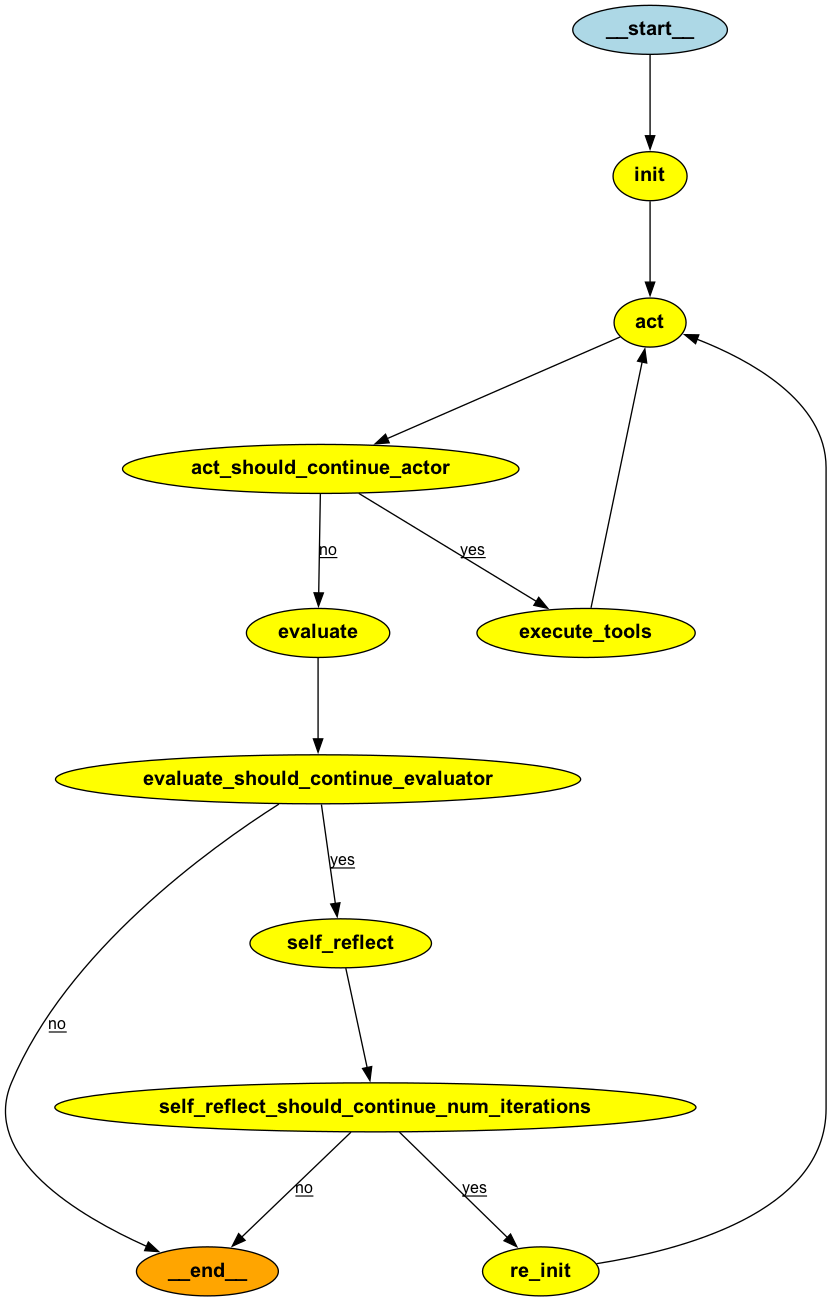

In [16]:
from IPython.display import Image


Image(reflexion.get_graph().draw_png())

## Invoking strategy

In [18]:
reflexion.invoke(
    {"inputs": {"inputs": "1 1 4 6"}},
    {"recursion_limit": 1000},
)

{'inputs': {'inputs': '1 1 4 6'},
 'agent_outcome': AgentFinish(return_values={'output': 'To obtain 24 from the numbers 1, 1, 4, and 6, you can use the following expression: \n\n(6 * 4) * (1 + 1) = 24'}, log='To obtain 24 from the numbers 1, 1, 4, and 6, you can use the following expression: \n\n(6 * 4) * (1 + 1) = 24'),
 'evaluator_score': 1.0,
 'evaluator_should_continue': False,
 'self_reflections': ['I failed to find a solution in my previous attempt due to a lack of considering the straightforward multiplication operation to reach the target number. To improve my approach, I should always start by trying basic operations like multiplication when faced with multiple numbers, as they can often lead to the desired outcome efficiently.',
  'Great job on finding a solution to the Game of 24 task this time! Your new approach efficiently utilized multiplication and division operations to reach the target number. In your self-reflection, you can consider exploring different combinations o